# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
import numpy
import matplotlib
import sklearn

# Chapter 11 - Implementing a Multi-layer Artificial Neural Network from Scratch


### Overview

- [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)
  - [Single-layer neural network recap](#Single-layer-neural-network-recap)
  - [Introducing the multi-layer neural network architecture](#Introducing-the-multi-layer-neural-network-architecture)
  - [Activating a neural network via forward propagation](#Activating-a-neural-network-via-forward-propagation)
- [Classifying handwritten digits](#Classifying-handwritten-digits)
  - [Obtaining the MNIST dataset](#Obtaining-the-MNIST-dataset)
  - [Implementing a multi-layer perceptron](#Implementing-a-multi-layer-perceptron)
  - [Coding the neural network training loop](#Coding-the-neural-network-training-loop)
  - [Evaluating the neural network performance](#Evaluating-the-neural-network-performance)
- [Training an artificial neural network](#Training-an-artificial-neural-network)
  - [Computing the loss function](#Computing-the-loss-function)
  - [Developing your intuition for backpropagation](#Developing-your-intuition-for-backpropagation)
  - [Training neural networks via backpropagation](#Training-neural-networks-via-backpropagation)
- [Convergence in neural networks](#Convergence-in-neural-networks)
- [Summary](#Summary)

<br>
<br>

In [3]:
from IPython.display import Image
%matplotlib inline

# Classifying handwritten digits

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [4]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [5]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

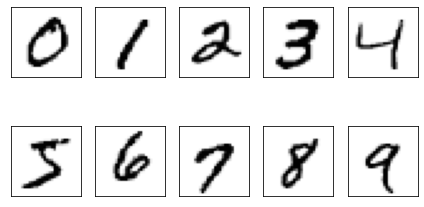

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

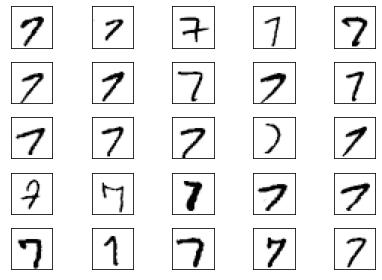

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [8]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [9]:
import numpy as np

In [10]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [11]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [12]:
import numpy as np

num_epochs = 100
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

Defining a function to compute the loss and accuracy

In [13]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

In [14]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [15]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [16]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=100, learning_rate=0.1)

Epoch: 001/100 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/100 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/100 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/100 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/100 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/100 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/100 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/100 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/100 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/100 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/100 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/100 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/100 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/100 | Train MSE: 0.01 | Train Acc: 92.80

## Evaluating the neural network performance

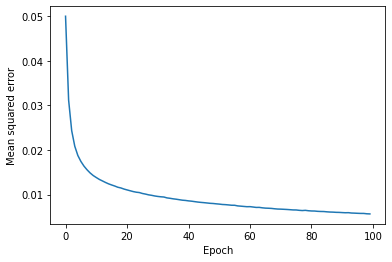

In [17]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

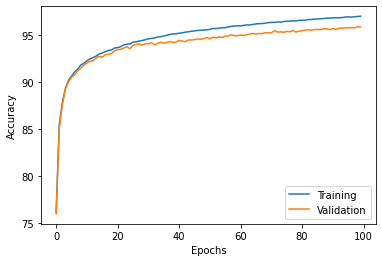

In [18]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [19]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 95.44%


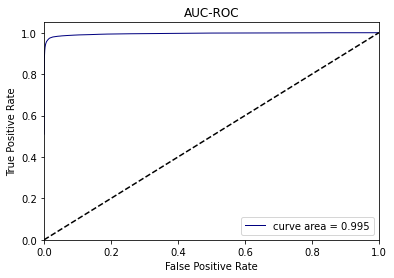

In [51]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

n_classes = 10
X_test_subset = X_test
y_test_subset = y_test
onehot_targets = int_to_onehot(y_test_subset, num_labels=n_classes)

_, probas = model.forward(X_test_subset)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(onehot_targets[:, i], probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
roc_auc["macro"]

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="curve area = {0:0.3f}".format(roc_auc["macro"]),
    color="navy",
    linewidth=1,
)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC")
plt.legend(loc="lower right")
plt.show()

Plot failure cases:

In [20]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

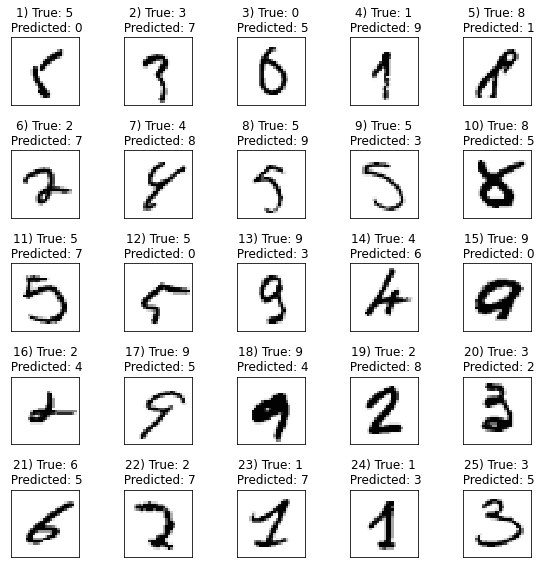

In [21]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

## Implementing a model with two hidden layers

In [22]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP_2_hidden_layers:

    def __init__(self, num_features, num_hidden, num_hidden2, num_classes, random_seed=42):
        super().__init__()
        
        rng = np.random.RandomState(random_seed)

        self.num_classes = num_classes
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden))
        self.bias_h2 = np.zeros(num_hidden2)
        
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        z_h2 = np.dot(a_h, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_h2, a_out

    def backward(self, x, a_h, a_h2, a_out, y):  
        y_onehot = int_to_onehot(y, self.num_classes)
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out) 
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        d_z_out__dw_out = a_h2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        d_z_out_d_a_h2 = self.weight_out
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
        d_loss__d_z_h2 = np.dot(delta_out, d_z_out_d_a_h2) * d_a_h2__d_z_h2
        d_z_h2__d_w_h2 = a_h
        d_loss__d_w_h2 = np.dot(d_loss__d_z_h2.T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum(d_loss__d_z_h2, axis=0)

        d_z_h2__d_a_h = self.weight_h2
        d_a_h__d_z_h = a_h * (1. - a_h)
        d_loss__d_z_h = np.dot(d_loss__d_z_h2, d_z_h2__d_a_h) * d_a_h__d_z_h
        d_z_h__d_w_h = x
        d_loss__d_w_h = np.dot(d_loss__d_z_h.T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum(d_loss__d_z_h, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h, d_loss__d_b_h)

In [23]:
model2 = NeuralNetMLP_2_hidden_layers(num_features=28 * 28,
                     num_hidden=50,
                     num_hidden2=50,
                     num_classes=10)

## Coding the two layer train loop

In [24]:
def compute_mse_and_acc2(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [25]:
def train2(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc2(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc2(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [26]:
np.random.seed(42) # for the training set shuffling

epoch_loss2, epoch_train_acc2, epoch_valid_acc2 = train2(
    model2, X_train, y_train, X_valid, y_valid,
    num_epochs=100, learning_rate=0.1)

Epoch: 001/100 | Train MSE: 0.09 | Train Acc: 15.53% | Valid Acc: 15.72%
Epoch: 002/100 | Train MSE: 0.09 | Train Acc: 23.79% | Valid Acc: 23.74%
Epoch: 003/100 | Train MSE: 0.08 | Train Acc: 47.82% | Valid Acc: 49.32%
Epoch: 004/100 | Train MSE: 0.06 | Train Acc: 58.64% | Valid Acc: 59.54%
Epoch: 005/100 | Train MSE: 0.05 | Train Acc: 70.56% | Valid Acc: 71.42%
Epoch: 006/100 | Train MSE: 0.04 | Train Acc: 75.67% | Valid Acc: 75.56%
Epoch: 007/100 | Train MSE: 0.03 | Train Acc: 81.37% | Valid Acc: 81.36%
Epoch: 008/100 | Train MSE: 0.03 | Train Acc: 85.41% | Valid Acc: 85.32%
Epoch: 009/100 | Train MSE: 0.03 | Train Acc: 87.42% | Valid Acc: 87.62%
Epoch: 010/100 | Train MSE: 0.02 | Train Acc: 88.57% | Valid Acc: 88.70%
Epoch: 011/100 | Train MSE: 0.02 | Train Acc: 89.44% | Valid Acc: 89.36%
Epoch: 012/100 | Train MSE: 0.02 | Train Acc: 90.10% | Valid Acc: 89.92%
Epoch: 013/100 | Train MSE: 0.02 | Train Acc: 90.62% | Valid Acc: 90.48%
Epoch: 014/100 | Train MSE: 0.02 | Train Acc: 90.90

## Evaluating the two layer model

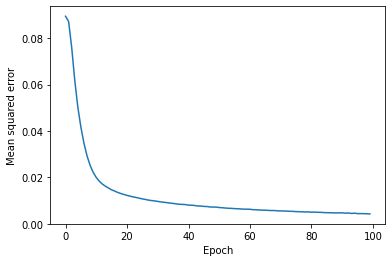

In [27]:
plt.plot(range(len(epoch_loss2)), epoch_loss2)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

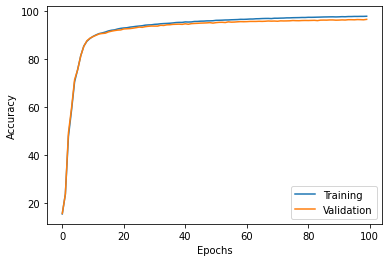

In [28]:
plt.plot(range(len(epoch_train_acc2)), epoch_train_acc2,
         label='Training')
plt.plot(range(len(epoch_valid_acc2)), epoch_valid_acc2,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [29]:
test_mse2, test_acc2 = compute_mse_and_acc2(model2, X_test, y_test)
print(f'Test accuracy: {test_acc2*100:.2f}%')

Test accuracy: 96.39%


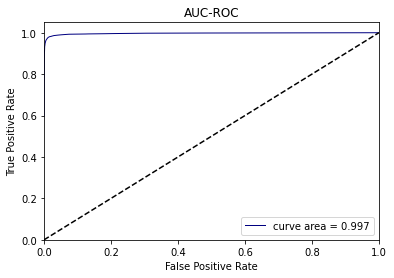

In [52]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

n_classes = 10
X_test_subset = X_test
y_test_subset = y_test
onehot_targets = int_to_onehot(y_test_subset, num_labels=n_classes)

_, _, probas = model2.forward(X_test_subset)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(onehot_targets[:, i], probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
roc_auc["macro"]

# Plot macro-ROC curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="curve area = {0:0.3f}".format(roc_auc["macro"]),
    color="navy",
    linewidth=1,
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC")
plt.legend(loc="lower right")
plt.show()

## keras model

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

hidden_units = 500
input_size = 28*28
num_labels = 10
dropout = 0.4

model3 = Sequential()
model3.add(Dense(hidden_units, input_dim=input_size))
model3.add(Activation('relu'))
model3.add(Dropout(dropout))
model3.add(Dense(hidden_units))
model3.add(Activation('relu'))
model3.add(Dropout(dropout))
model3.add(Dense(num_labels))
model3.add(Activation('softmax'))

model3.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
model3.fit(X_train, y_train, epochs=100, batch_size=100)

Epoch 1/100
550/550 [==============================] - 9s 15ms/step - loss: 0.4415 - accuracy: 0.8605
Epoch 2/100
550/550 [==============================] - 8s 15ms/step - loss: 0.2529 - accuracy: 0.9215
Epoch 3/100
550/550 [==============================] - 8s 14ms/step - loss: 0.2125 - accuracy: 0.9351
Epoch 4/100
550/550 [==============================] - 9s 17ms/step - loss: 0.1911 - accuracy: 0.9417
Epoch 5/100
550/550 [==============================] - 9s 17ms/step - loss: 0.1721 - accuracy: 0.9465
Epoch 6/100
550/550 [==============================] - 9s 16ms/step - loss: 0.1602 - accuracy: 0.9503
Epoch 7/100
550/550 [==============================] - 14s 25ms/step - loss: 0.1503 - accuracy: 0.9533
Epoch 8/100
550/550 [==============================] - 11s 20ms/step - loss: 0.1482 - accuracy: 0.9537
Epoch 9/100
550/550 [==============================] - 8s 15ms/step - loss: 0.1412 - accuracy: 0.9568
Epoch 10/100
550/550 [==============================] - 8s 14ms/step - loss: 0.1

In [46]:
loss, acc = model3.evaluate(X_test, y_test, batch_size=100)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

100/100 [==============================] - 1s 6ms/step - loss: 0.0860 - accuracy: 0.9795

Test accuracy: 97.9%
